In [ ]:
print('Setup complete.')

# Token Inspector Demo

## Learning Objectives
- Understand how text is tokenized by different LLM models
- Explore subword tokenization and its implications
- See how token counts affect API costs and context limits
- Demonstrate context window truncation behavior

## Introduction to Tokenization

Large Language Models don't work directly with raw text. Instead, they convert text into **tokens** - the basic units of processing. Understanding tokenization is crucial for:

- **Cost estimation**: APIs charge per token
- **Context management**: Models have token limits (e.g., 4K, 8K, 128K tokens)
- **Performance optimization**: Fewer tokens = faster processing

In [ ]:
# Install required packages for Colab
!pip install tiktoken transformers matplotlib seaborn pandas

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import tiktoken


## Tokenization Basics

Let's start by looking at how different types of text get tokenized.

In [ ]:
def _resolve_encoding(preferred_model_hint: str | None = None):
    """
    Resolve a usable tiktoken encoding:
      1) encoding_for_model(preferred_model_hint) if provided & supported
      2) get_encoding('o200k_base')  (newer)
      3) get_encoding('cl100k_base') (widely available)
    Returns an encoding or None if tiktoken isn't available.
    """
    if tiktoken is None:
        return None

    if preferred_model_hint:
        return tiktoken.encoding_for_model(preferred_model_hint)


    for name in ("o200k_base", "cl100k_base"):
        return tiktoken.get_encoding(name)
 

    return None

# Prefer a modern hint; fallback sequence handles environments without o200k_base
encoding = _resolve_encoding(preferred_model_hint="gpt-4o-mini")


In [33]:
# Cell 2 — inspect_tokens(): count + per-token strings (explains what you saw like "13225")
# Explanation:
# - Token IDs are just integer indices into the tokenizer's BPE vocabulary.
#   They identify subword pieces like "Hello", " world", punctuation, spaces, etc.
#   (References: token IDs are vocabulary indices used for lookups.)  See citations in the chat.

def inspect_tokens(text: str, model_hint: str | None = None, show_details: bool = True):
    """
    Return (tokens, token_strings) and print summary.
    If tiktoken isn't available, falls back to an estimate (~3.7 chars/token).
    """
    enc = _resolve_encoding(model_hint) or encoding

    # No tiktoken -> estimate only
    if enc is None:
        est_tokens = max(1, math.ceil(len(text) / 3.7))
        print("[No tiktoken available] Estimated token count only.")
        print(f"Text: {text!r}")
        print(f"Chars: {len(text)}  |  ~Tokens: {est_tokens}  |  Ratio: {est_tokens/len(text):.2f}")
        return [], []

    toks = enc.encode(text)
    toks_str = []
    for tid in toks:
        try:
            toks_str.append(enc.decode([tid]))
        except Exception:
            toks_str.append("<UNK>")

    print(f"Text: {text!r}")
    print(f"Chars: {len(text)}  |  Tokens: {len(toks)}  |  Ratio: {len(toks)/len(text):.2f}")

    if show_details:
        print("\nToken breakdown:")
        for i, (tid, piece) in enumerate(zip(toks, toks_str)):
            display = repr(piece)[1:-1]
            print(f"{i:2d}: {tid:6d} → '{display}'")

    return toks, toks_str


In [34]:
inspect_tokens("Hello, world!", show_details=True)

Text: 'Hello, world!'
Chars: 13  |  Tokens: 4  |  Ratio: 0.31

Token breakdown:
 0:  13225 → 'Hello'
 1:     11 → ','
 2:   2375 → ' world'
 3:      0 → '!'


([13225, 11, 2375, 0], ['Hello', ',', ' world', '!'])

## Subword Tokenization Examples

Notice how tokenization handles different scenarios:

In [35]:
test_cases = [
    "artificial intelligence",            # Common words
    "supercalifragilisticexpialidocious", # Long uncommon word
    "AI ML NLP GPT",                      # Acronyms
    "print('Hello, world!')",             # Code
    "🤖🧠💻🚀",                             # Emojis
    "résumé naïve café",                  # Accented characters
    "123456789",                          # Numbers
]

results = []
for text in test_cases:
    toks, _ = inspect_tokens(text, show_details=False)
    results.append({
        "text": text,
        "chars": len(text),
        "tokens": len(toks),
        "ratio_tokens_per_char": (len(toks) / len(text)) if len(text) else float("nan"),
    })
    print("─" * 50)

df = pd.DataFrame(results)
print("\n📊 Tokenization Summary:")
print(df.to_string(index=False))


Text: 'artificial intelligence'
Chars: 23  |  Tokens: 3  |  Ratio: 0.13
──────────────────────────────────────────────────
Text: 'supercalifragilisticexpialidocious'
Chars: 34  |  Tokens: 10  |  Ratio: 0.29
──────────────────────────────────────────────────
Text: 'AI ML NLP GPT'
Chars: 13  |  Tokens: 4  |  Ratio: 0.31
──────────────────────────────────────────────────
Text: "print('Hello, world!')"
Chars: 22  |  Tokens: 7  |  Ratio: 0.32
──────────────────────────────────────────────────
Text: '🤖🧠💻🚀'
Chars: 4  |  Tokens: 9  |  Ratio: 2.25
──────────────────────────────────────────────────
Text: 'résumé naïve café'
Chars: 17  |  Tokens: 5  |  Ratio: 0.29
──────────────────────────────────────────────────
Text: '123456789'
Chars: 9  |  Tokens: 3  |  Ratio: 0.33
──────────────────────────────────────────────────

📊 Tokenization Summary:
                              text  chars  tokens  ratio_tokens_per_char
           artificial intelligence     23       3               0.130435
supercal

## Context Window Limits Demo

Let's simulate what happens when you approach context limits:

In [30]:
def simulate_context_limit(text: str, max_tokens: int = 100, enc=None):
    """
    Simulate truncating a string to a token limit.
    Uses tiktoken if available; otherwise approximates by chars.
    """
    enc = enc or encoding
    if enc is not None:
        toks = enc.encode(text)
        print(f"Original text tokens: {len(toks)}")
        print(f"Context limit: {max_tokens}")
        if len(toks) <= max_tokens:
            print("✅ Text fits within context limit")
            return text
        print(f"⚠️  Text exceeds limit by {len(toks) - max_tokens} tokens")
        truncated = enc.decode(toks[:max_tokens])
        print(f"Truncated to: {max_tokens} tokens")
        print(f"Lost: {len(toks) - max_tokens} tokens")
        return truncated
    else:
        # Approx fallback: ~3.7 chars/token
        est_tokens = max(1, math.ceil(len(text) / 3.7))
        print(f"(Approx) Original tokens: {est_tokens} | Limit: {max_tokens}")
        if est_tokens <= max_tokens:
            print("✅ (Approx) Fits")
            return text
        ratio = max_tokens / est_tokens
        cut = max(1, int(len(text) * ratio))
        print(f"(Approx) Truncating to {cut} characters")
        return text[:cut]


print("🔍 Testing context limit behavior:\n")
truncated = simulate_context_limit(long_text, max_tokens=50, enc=encoding)
print("\n📝 Truncated text:\n", truncated)


🔍 Testing context limit behavior:

Original text tokens: 137
Context limit: 50
⚠️  Text exceeds limit by 87 tokens
Truncated to: 50 tokens
Lost: 87 tokens

📝 Truncated text:
 Large Language Models (LLMs) have revolutionized the field of artificial intelligence by demonstrating remarkable capabilities in understanding and generating human-like text. These models, such as GPT-4, Claude, and others, are trained on vast amounts of text data and


## Cost Estimation Helper

Text: 'Hello, world!'
Chars: 13  |  Tokens: 4  |  Ratio: 0.31
API Cost comparison (example prompt):
     model  input_tokens  output_tokens  total_cost_usd
gpt-5-mini             4            150        0.000301
     gpt-5             4            150        0.001505


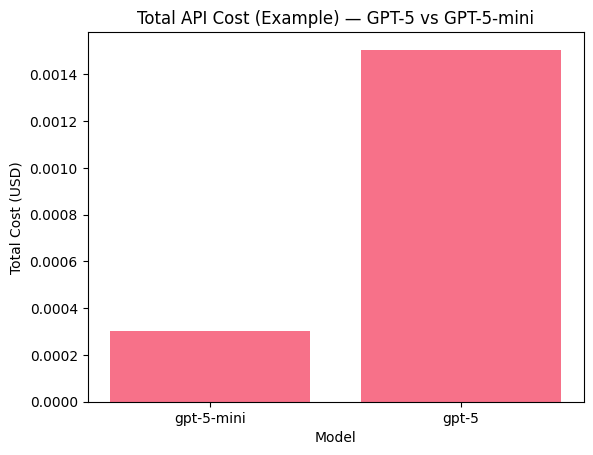

In [36]:

PRICES_PER_M = {
    "gpt-5":      {"input_per_m": 1.25, "output_per_m": 10.00},
    "gpt-5-mini": {"input_per_m": 0.25, "output_per_m": 2.00},
}

def api_cost(input_tokens: int, output_tokens: int, model: str) -> float:
    """
    Compute API cost using OpenAI published rates (USD).
    """
    if model not in PRICES_PER_M:
        raise ValueError(f"Unknown model: {model}")
    p = PRICES_PER_M[model]
    return (input_tokens / 1_000_000) * p["input_per_m"] + (output_tokens / 1_000_000) * p["output_per_m"]

# Example scenario: use your "Hello, world!" prompt for input and 150 output tokens
hello_tokens, _ = inspect_tokens("Hello, world!", show_details=False)
example_input_tokens  = len(hello_tokens)
example_output_tokens = 150

rows = []
for m in ["gpt-5-mini", "gpt-5"]:
    total = api_cost(example_input_tokens, example_output_tokens, m)
    rows.append({
        "model": m,
        "input_tokens": example_input_tokens,
        "output_tokens": example_output_tokens,
        "total_cost_usd": total
    })

cost_df = pd.DataFrame(rows)
print("API Cost comparison (example prompt):")
print(cost_df.to_string(index=False))

# Bar chart: model vs total cost
plt.figure()
plt.bar(cost_df["model"], cost_df["total_cost_usd"])
plt.title("Total API Cost (Example) — GPT-5 vs GPT-5-mini")
plt.xlabel("Model")
plt.ylabel("Total Cost (USD)")
plt.show()


## Key Takeaways

From this token inspection demo, you've learned:

1. **Tokenization varies by content type**:
   - Common words: ~0.75 tokens per character
   - Code: ~1.0 tokens per character
   - Rare/long words: >1.0 tokens per character

2. **Context limits are hard constraints**:
   - Text gets truncated, not compressed
   - Plan your prompts within token budgets

3. **Cost scales with tokens**:
   - Input and output tokens are priced differently
   - Different models have different pricing

4. **Practical implications**:
   - Always count tokens for production systems
   - Consider chunking strategies for long documents
   - Monitor token usage for cost control

## Next Steps

In the next lab, you'll build a tokenization and costing calculator to practice these concepts hands-on!